# Importing Libraries

In [4]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

print(sys.executable)

/Users/mariatirado/citibike_2022_weather/venv/bin/python


In [5]:
import os
os.listdir("data/processed")[:50]

['citibike_trips_weather_merged_2022.csv', 'noaa_lga_daily_2022.csv']

# Creating a line plot of the temperatures for 2022

In [6]:
weather = pd.read_csv("data/processed/noaa_lga_daily_2022.csv")
weather.head()

,date,PRCP,TMAX,TMIN
0,2022-01-01,19.3,13.9,10.0
1,2022-01-02,1.0,15.6,3.9
2,2022-01-03,0.0,3.9,-4.3
3,2022-01-04,0.0,2.2,-6.0
4,2022-01-05,6.1,8.9,0.0


In [7]:
weather["date"] = pd.to_datetime(weather["date"])
weather = weather.sort_values("date")

In [8]:
# Creting average temperature 
weather["TAVG"] = (weather["TMAX"] + weather["TMIN"]) / 2

In [9]:
weather.head()

,date,PRCP,TMAX,TMIN,TAVG
0,2022-01-01,19.3,13.9,10.0,11.95
1,2022-01-02,1.0,15.6,3.9,9.75
2,2022-01-03,0.0,3.9,-4.3,-0.20
3,2022-01-04,0.0,2.2,-6.0,-1.90
4,2022-01-05,6.1,8.9,0.0,4.45


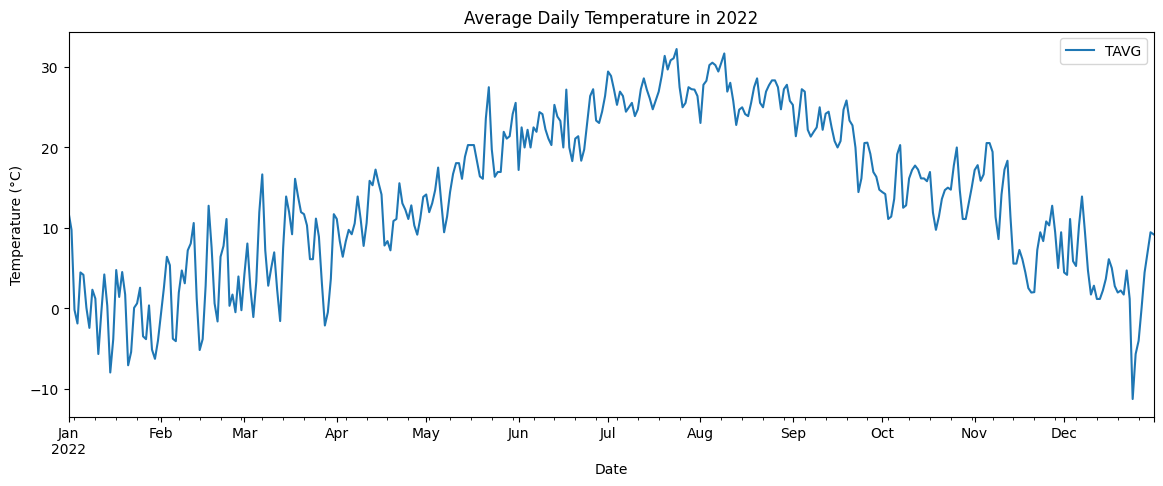

In [10]:
# Ploting 
weather.plot(x="date", y="TAVG", kind="line", figsize=(14,5), title="Average Daily Temperature in 2022")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

# Creating a column with the count of trips per day

In [11]:
os.listdir("data/raw")

['citibike_2022', '.DS_Store', '2022-citibike-tripdata']

In [12]:
# Importing a helper library

import glob

In [13]:
folder_path = "data/raw/citibike_2022"
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

len(all_files)

0

In [14]:
# Search inside all subfolders too

folder_path = "data/raw/citibike_2022"
all_files = glob.glob(os.path.join(folder_path, "**/*.csv"), recursive=True)

len(all_files)

36

In [15]:
# Read all files and combine them 

df_list = []

for file in all_files:
    temp_df = pd.read_csv(file, low_memory=False)
    df_list.append(temp_df)

trips = pd.concat(df_list, ignore_index=True)

In [16]:
trips.shape

(29838806, 13)

In [17]:
# Identifying  the timestamp column

trips.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='str')

In [18]:
# Converting timestamps safely

trips["started_at"] = pd.to_datetime(trips["started_at"], errors="coerce")
trips = trips.dropna(subset=["started_at"])

In [20]:
# Extract the calendar day

trips["date"] = trips["started_at"].dt.date

In [21]:
# Creating daily ride counts

daily_trips = trips.groupby("date").size().reset_index(name="trip_count")
daily_trips.head()

,date,trip_count
0,2021-01-30,1
1,2021-02-15,1
2,2021-03-11,1
3,2021-03-14,1
4,2021-03-31,1


In [22]:
# Filter by year 

trips_2022 = trips[trips["started_at"].dt.year == 2022].copy()

In [23]:
trips_2022["started_at"].dt.year.value_counts()

started_at
2022    29838166
Name: count, dtype: int64

In [24]:
# Creating date + daily trip counts

trips_2022["date"] = trips_2022["started_at"].dt.date

daily_trips = (
    trips_2022.groupby("date")
    .size()
    .reset_index(name="trip_count")
)

daily_trips["date"] = pd.to_datetime(daily_trips["date"])
daily_trips.head()

,date,trip_count
0,2022-01-01,20428
1,2022-01-02,43009
2,2022-01-03,33189
3,2022-01-04,36842
4,2022-01-05,34230


In [25]:
daily_trips.shape

(365, 2)

In [26]:
# Merge with weather 

combined = pd.merge(weather, daily_trips, on="date", how="inner")
combined.shape
combined.head()

,date,PRCP,TMAX,TMIN,TAVG,trip_count
0,2022-01-01,19.3,13.9,10.0,11.95,20428
1,2022-01-02,1.0,15.6,3.9,9.75,43009
2,2022-01-03,0.0,3.9,-4.3,-0.20,33189
3,2022-01-04,0.0,2.2,-6.0,-1.90,36842
4,2022-01-05,6.1,8.9,0.0,4.45,34230


# Creating a line chart of bike trip counts and temperatures plotted on a dual axis

In [27]:
# Making sure the date is sorted 

combined = combined.sort_values("date")

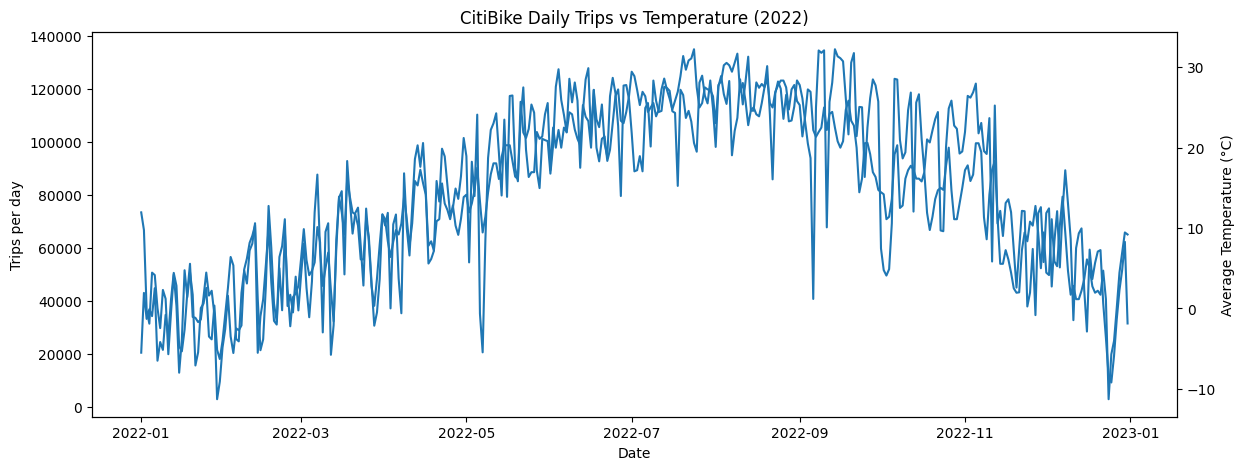

In [28]:
# Dual axis plot 

fig, ax1 = plt.subplots(figsize=(14,5))

# LEFT AXIS -> trips
ax1.plot(combined["date"], combined["trip_count"])
ax1.set_xlabel("Date")
ax1.set_ylabel("Trips per day")

# RIGHT AXIS -> temperature
ax2 = ax1.twinx()
ax2.plot(combined["date"], combined["TAVG"])
ax2.set_ylabel("Average Temperature (°C)")

plt.title("CitiBike Daily Trips vs Temperature (2022)")
plt.show()

# Comments

I used Matplotlib’s object-oriented interface to create a dual-axis plot. First, I created a figure and axis with plt.subplots(). I plotted daily trip counts on the first axis and then used twinx() to create a second y-axis for the average temperature. This allows two variables with different scales to be visualized over the same time period.

# Histogram of trip duration

In [29]:
trips.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date'],
      dtype='str')

In [32]:
# Creating trip duration column 

trips["started_at"] = pd.to_datetime(trips["started_at"], errors="coerce")
trips["ended_at"] = pd.to_datetime(trips["ended_at"], errors="coerce")
trips = trips.dropna(subset=["started_at", "ended_at"])

# duration in minutes
trips["tripduration"] = (trips["ended_at"] - trips["started_at"]).dt.total_seconds() / 60

In [33]:
trips = trips[(trips["tripduration"] > 0) & (trips["tripduration"] < 180)]

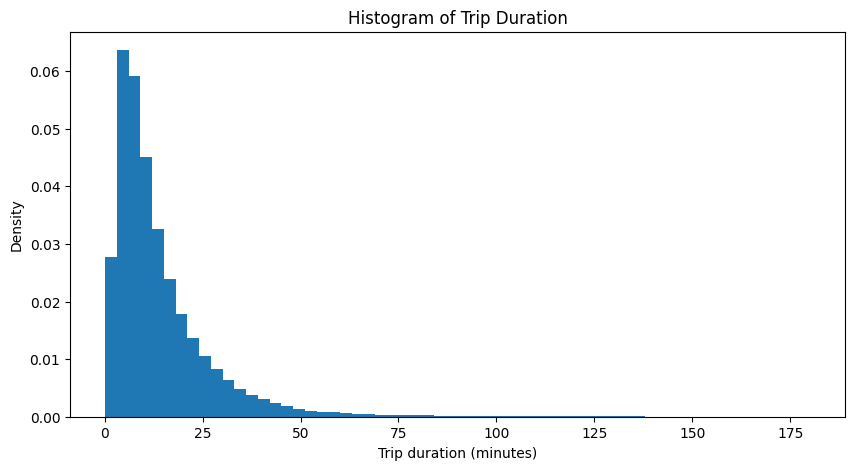

In [34]:
# Plot histogram

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(trips["tripduration"].dropna(), bins=60, density=True)
ax.set_title("Histogram of Trip Duration")
ax.set_xlabel("Trip duration (minutes)")
ax.set_ylabel("Density")
plt.show()

# Adding a curve following the bins

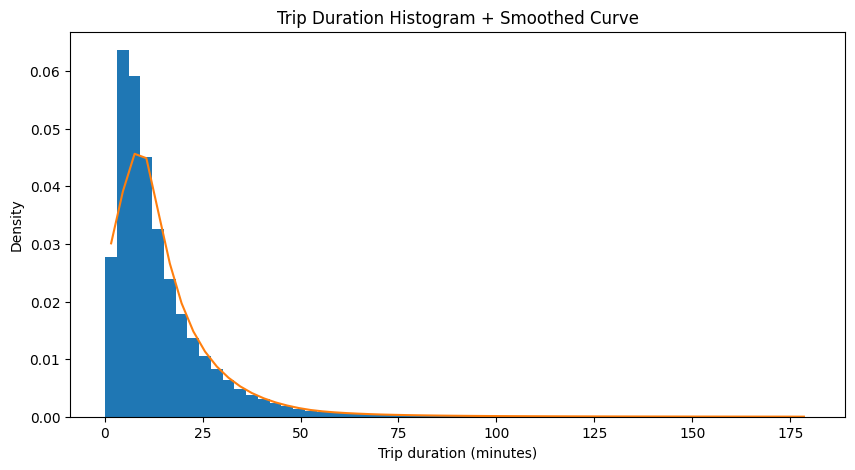

In [36]:
import numpy as np

x = trips["tripduration"].dropna().to_numpy()
x = x[(x > 0) & (x < 180)]

counts, bin_edges = np.histogram(x, bins=60, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# simple moving average smoothing
window = 5
smooth = np.convolve(counts, np.ones(window)/window, mode="same")

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(x, bins=60, density=True)
ax.plot(bin_centers, smooth)
ax.set_title("Trip Duration Histogram + Smoothed Curve")
ax.set_xlabel("Trip duration (minutes)")
ax.set_ylabel("Density")
plt.show()

# One figure with two axes (subplots): bar chart usertype + pie chart gender (

In [38]:
trips.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date', 'tripduration'],
      dtype='str')

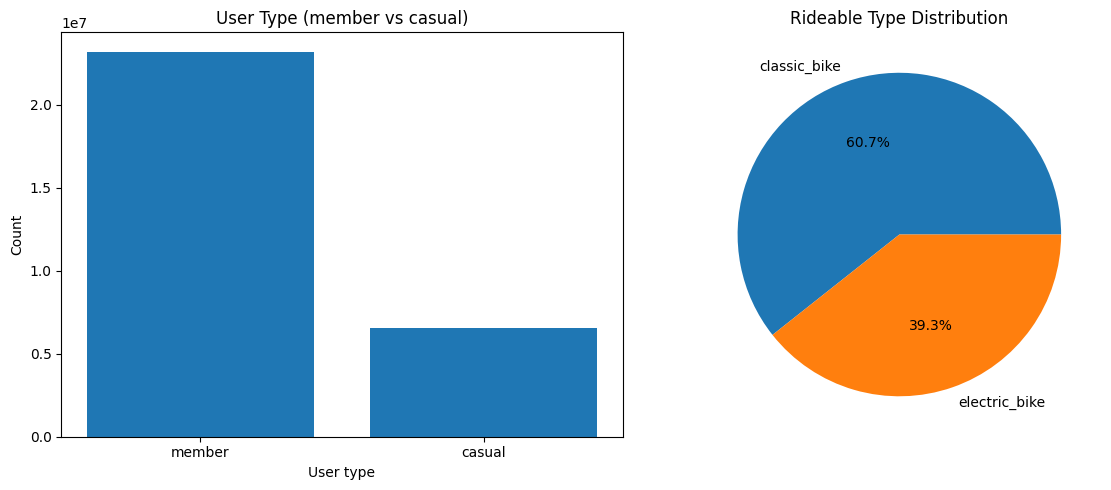

In [40]:
usertype_counts = trips["member_casual"].value_counts(dropna=False)
rideable_counts = trips["rideable_type"].value_counts(dropna=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Bar chart: user type
ax1.bar(usertype_counts.index.astype(str), usertype_counts.values)
ax1.set_title("User Type (member vs casual)")
ax1.set_xlabel("User type")
ax1.set_ylabel("Count")

# Pie chart: rideable type
ax2.pie(rideable_counts.values, labels=rideable_counts.index.astype(str), autopct="%1.1f%%")
ax2.set_title("Rideable Type Distribution")

plt.tight_layout()
plt.show()